# High Order Linear Multistep Preconditioners

## Constructing linear multistep methods (LMMs)
LMMs are based on Taylor expanding the solution in time and then summing solutions and right hand side evaluations at different steps to cancel as many terms in the Taylor expansion.
The Taylor expansion of the solution at time $t$, which we want to solve for is
$$u(t-h) = \sum^{p}_{i=0}\frac{(-h)^i}{i!}\partial_t^i u(t) = \mathcal{O}(h^{p+1}).$$
Since we want to compute $u(t)$, we want to cancel all other terms in the Taylor expansion.

The solutions at previous steps share the same expansion, but the right hand side evaluations are missing the solution and a power of the step size.
Their expansion is
$$f(t-h) = \sum^p_{i=1}\frac{(-h)^{(i-1)}}{(i-1)!}\partial_t^{i}u(t) + \mathcal{O}(h^{p+1}).$$

The linear multistep method will then look like
$$u(t) = \sum_{i=0}^p \left(\alpha_i u(t-h_i) + \beta_i f\left(u\left(t-h_i\right), t-h_i\right)\right),$$
and we need to choose $\alpha$ and $\beta$ in a way that suits us and that cancels the most possible terms in the Taylor expansion.

What suits us best is mainly determined by what we have available, which is in the pySDC implementation the initial conditions and the right hand side evaluations at all the nodes.
That means with $h_i$ the time differences to where we want to solve for in descending order: $\alpha_0=1$ and $\beta_i \neq 0$.
In particular, $\beta_p\neq 0$, to make the scheme implicit.

In order to cancel as many terms as we can, we setup a linear system of equations that carries the coefficients of the Taylor expansion.
We construct a matrix $A$ with
$$A_{ij} = \cases{(-h_i)^j / j!, & j = 0\\
                  (-h_i)^{(j-1)} / (j-1)!, & i,j > 0}.$$
We will then procees to solve a system $Ax=b$, which means we need a vector $b$ on the right hand side.
Since we want to solve for the solution at time $t$ itself and want to cancel all other terms, we need a one in the first entry, corresponding to $u(t)$ and zeros everywhere else:
$$b = \delta_{i0}.$$

Conveniently for us, $u(t-h_0)$ is the only term carrying $u(t)$ in its expansion, and since we want a one in the corresponding row of the solution, we will always get $\alpha_0=1$, which is exactly what we wanted!
The remaining coefficients make up a single row of the preconditioner and are the $\beta_i$ coefficients that will be multiplied to the right hand side evaluations in the sweeps.

Crucially, we get increase the order of the LMM by one in each row of the preconditioner.
In the first row, we get the trapezoidal rule (or implicit Euler, if we set $\beta_0=0$), and then we gain an order in the expansions with each row.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pySDC.projects.Resilience.accuracy_check import plot_all_errors, plot_orders
from pySDC.projects.Resilience.vdp import run_vdp
from pySDC.projects.Resilience.advection import run_advection
from pySDC.projects.Resilience.piline import run_piline
from pySDC.playgrounds.Preconditioners.heat import run_heat

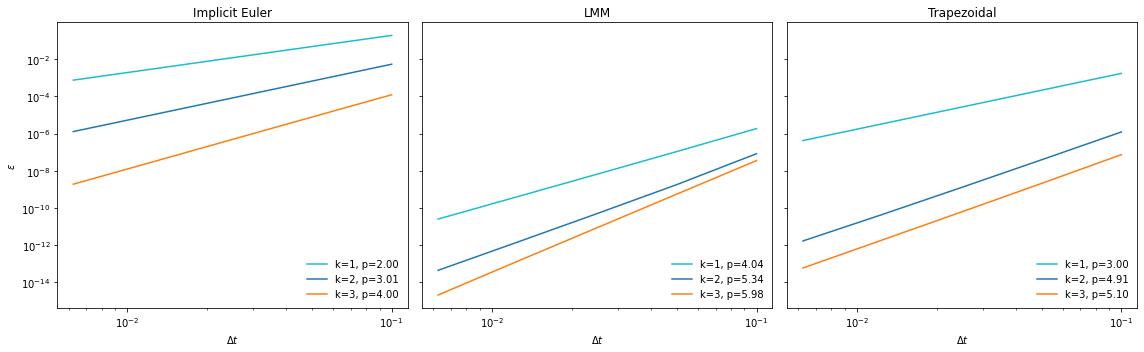

In [2]:
IE_desc = {'sweeper_params': {'QI': 'IE'}}
Taylor_desc = {'sweeper_params': {'QI': 'LMM'}}
trap_desc = {'sweeper_params': {'QI': 'TRAP'}}


ks = [1, 2, 3]

def compare_preconditioners(prob, dt_list, ks, Tend_fixed):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
    descriptions = [IE_desc, Taylor_desc, trap_desc]
    titles = ['Implicit Euler', 'LMM', 'Trapezoidal']
    for i in range(len(descriptions)):
        plot_orders(axs[i], ks, True, Tend_fixed=Tend_fixed, custom_description=descriptions[i], dt_list=dt_list, prob=prob)
        axs[i].set_title(titles[i])
        if i > 0:
            axs[i].set_ylabel('')

    fig.tight_layout()


compare_preconditioners(run_piline, 0.1 * 2.**(-np.arange(5)), ks, 0.1)

What you see above is the order for the pi-line problem.
$k$ is the number of sweeps and $p$ is the order of the scheme.

The left panel shows the expected $p=k+1$, but the other panels show something akin to $p=2k+1$ until we reach three sweeps at which point, the quadrature rule is not high order enough, since we use only three Gauss-Radau nodes.

This looks nice! We did no extra work and yet we got a higher order method!

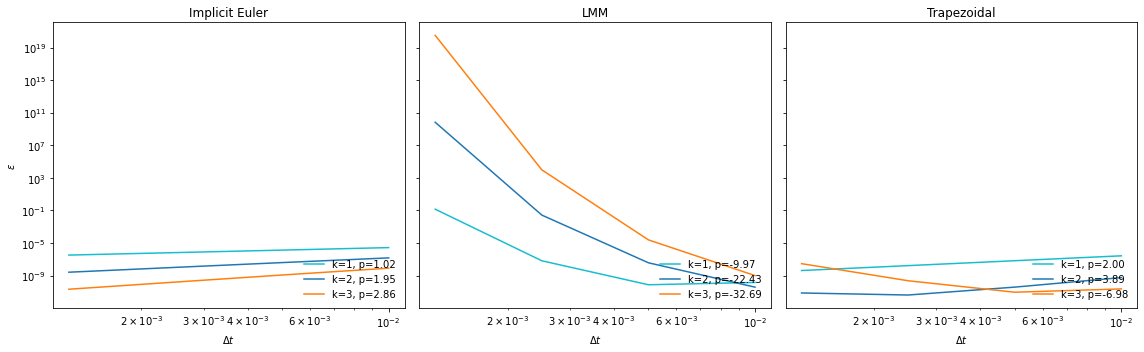

In [3]:
Tend = 1e-2
compare_preconditioners(run_heat, Tend * 2.**(-np.arange(4)), ks, Tend)
#compare_preconditioners(run_heat, [0.1, 0.05], [1, 2, 3], 0.2)

This is all messed up! We get one order too little with the Euler precondtitioner. Something is off!

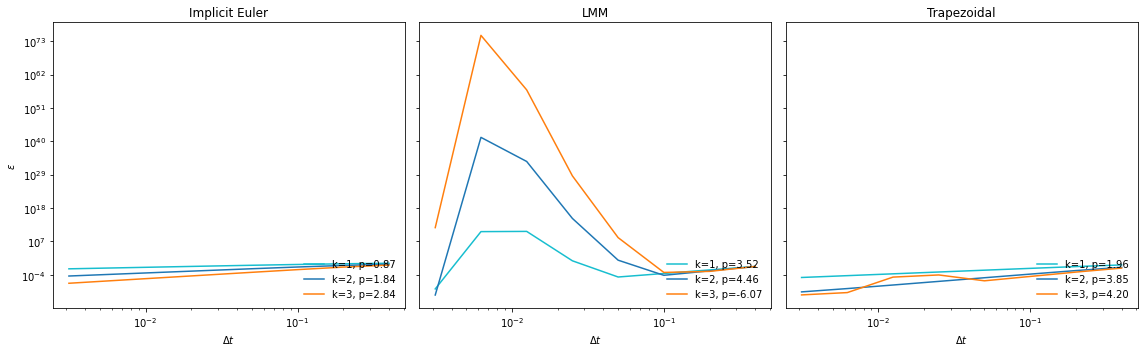

In [4]:
Tend = 4e-1
compare_preconditioners(run_advection, Tend * 2.**(-np.arange(8)), ks, Tend)

## Put this somewhere:

A true RK scheme would expand $f$ in two variables to cancel the variations caused by the inaccurate $f$ evaluations. That means this is not a real Runge Kutta method! Maybe this is why the preconditioner is so bad for PDE's

I actually derive linear multistep methods, but some of them are unstable.
I need to enforce stability somehow, which I think is entirely possible.

## Stability
### Consistency
Since the only coefficient for $u$ is one for the initial conditions (but on the right hand side), we get a first characteristic polynomial
$$\rho(r) = r^p - 1,$$
which means that indeed 1 is a root and we satisfied a condition for consistency.
Actually, the roots are all distict with modulus equal to or smaller than 1, which is a condition for convergence.

The second characteristic polynomial, on the other hand, collects quite a few coefficients and is equal to
$$\sigma(r) = \sum^{p}_{i=0}\beta_ir^i.$$
The second condition for consistency is that $\rho^\prime(1) = \sigma(1)$, which means in our case 
$$p = \sum^{p}_{i=0}\beta_i$$